## CatBoost

In [1]:
import sys
import os

import numpy as np
from tqdm import tqdm

import pandas as pd
from pymystem3 import Mystem
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words("russian"))
def preprocessor(text):
    text = text.lower()
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)
    text = " ".join(mystem.lemmatize(text))
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

tf_idf = vectorizer.fit_transform(X.release)

CatBoost на наших данных обучается дольше, чем остальные бустинги, поэтому запустить перебор по полной сетке возможных значений с помощью optuna очень накладно по времени. Попытаемся аналитически подобрать гиперпараметры.

Сначала на параметрах по умолчанию посмотрим, какую максимальную глюбину дерева стоит рассматривать.

100%|██████████| 13/13 [11:06<00:00, 51.24s/it] 


<Axes: title={'center': 'Min on depth=8, iterations=64'}>

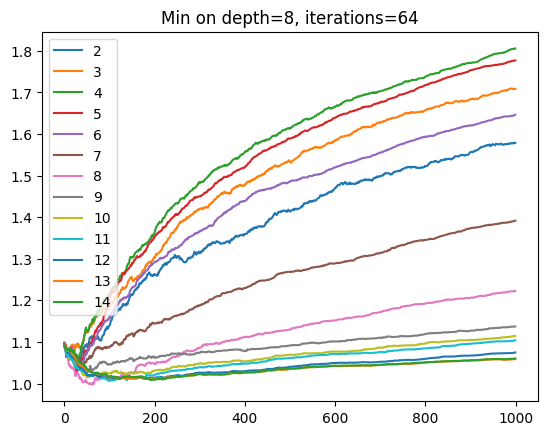

In [4]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y, test_size=0.2, random_state=42)
eval_dataset = Pool(data=X_val, label=y_val)
res = []
for depth in tqdm(range(2, 15)):
    model = CatBoostClassifier(
        max_depth=depth,
        loss_function='MultiClass',
        random_state=42,
        task_type="GPU",
    )
    model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)
    res.append(model.evals_result_['validation']['MultiClass'])
res_arr = np.array(res)
ij_min = np.unravel_index(res_arr.argmin(), res_arr.shape)
pd.DataFrame(res_arr.T, columns=range(2, 15)).plot(
    title=f"Min on depth={ij_min[0] + 2}, iterations={ij_min[1]}")

Видим, что на максимальной глубине 11, качество получается лучше. Будем использовать в дальнейнем подборе это значение.

100%|██████████| 5/5 [07:07<00:00, 85.43s/it] 


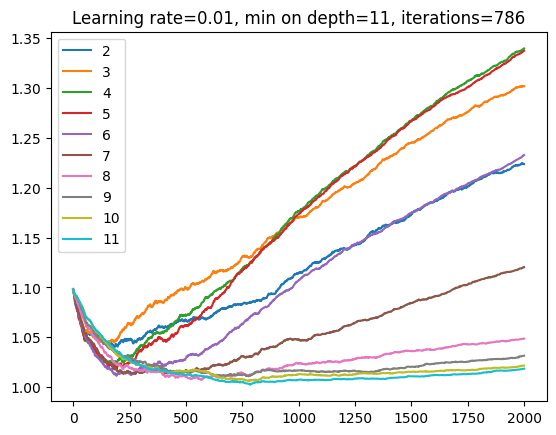

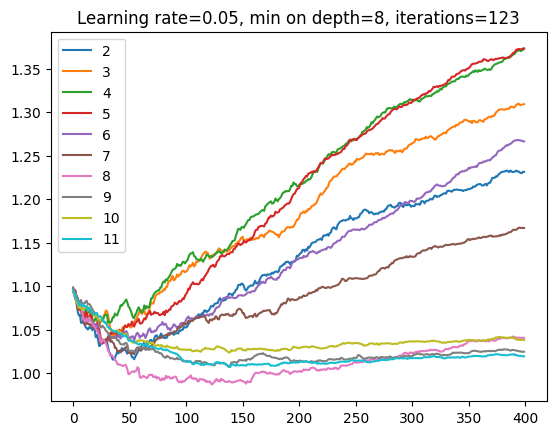

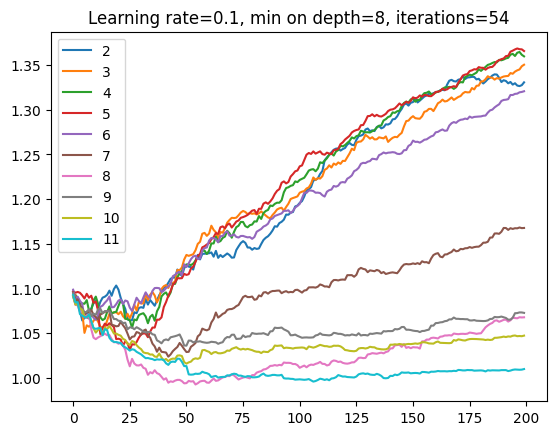

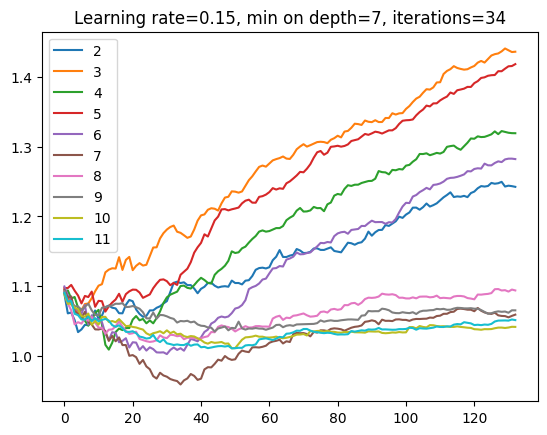

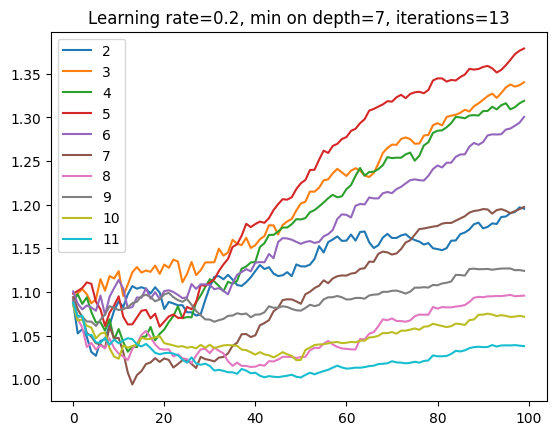

In [5]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y, test_size=0.2, random_state=42)
eval_dataset = Pool(data=X_val, label=y_val)
best_params = []
for lr in tqdm([0.01, 0.05, 0.1, 0.15, 0.2]):
    res = []
    for depth in range(2, 12):
        model = CatBoostClassifier(
            max_depth=depth,
            learning_rate=lr,
            iterations=int(20 / lr),
            loss_function='MultiClass',
            random_state=42,
            task_type="GPU",
        )
        model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)
        res.append(model.evals_result_['validation']['MultiClass'])
    res_arr = np.array(res)
    ij_min = np.unravel_index(res_arr.argmin(), res_arr.shape)
    best_params.append({'lr': lr, 'depth': ij_min[0] + 2, 'iterations': ij_min[1], 'loss': res_arr[ij_min[0], ij_min[1]]})
    pd.DataFrame(res_arr.T, columns=range(2, 12)).plot(
        title=f"Learning rate={lr}, min on depth={ij_min[0] + 2}, iterations={ij_min[1]}")

In [7]:
df_best_params = pd.DataFrame(best_params)
df_best_params

,lr,depth,iterations,loss
0,0.01,11,786,1.002724
1,0.05,8,123,0.986873
2,0.10,8,54,0.992781
3,0.15,7,34,0.958813
4,0.20,7,13,0.993908


              precision    recall  f1-score   support

        -1.0       0.64      0.61      0.62        23
         0.0       0.48      0.54      0.51        28
         1.0       0.71      0.63      0.67        19

    accuracy                           0.59        70
   macro avg       0.61      0.59      0.60        70
weighted avg       0.59      0.59      0.59        70



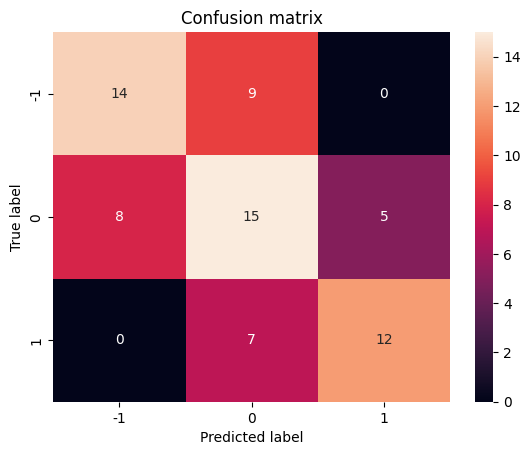

In [8]:
min_best_param = df_best_params[df_best_params['loss'] == df_best_params['loss'].min()]
model = CatBoostClassifier(
        max_depth=min_best_param['depth'].values[0],
        learning_rate=min_best_param['lr'].values[0],
        iterations=min_best_param['iterations'].values[0],
        loss_function='MultiClass',
        random_state=42,
        verbose=False,
        task_type="GPU",
    )
metric, model = calc_metrics(
    tf_idf,
    y,
    model,
    name="TF-IDF CatBoost"
)

In [9]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.742857,0.745614,0.749755,0.743050,0.840990,0.844114
K-neighbors tf_idf pca,0.728571,0.734787,0.727035,0.751111,0.816386,0.821299
K-neighbors word2vec,0.657143,0.637422,0.641441,0.745632,0.787306,0.789760
K-neighbors weighted word2vec,0.657143,0.637422,0.641441,0.745632,0.795419,0.797633
TF-IDF SelectFromModel Random Forest,0.642857,0.642165,0.627874,0.695332,0.798339,0.805117
TF-IDF PCA Random Forest,0.642857,0.640412,0.630462,0.685668,0.818108,0.823213
Word2Vec Random Forest,0.571429,0.571970,0.560586,0.603785,0.730344,0.735650
TF-IDF LigthGBM,0.514286,0.518519,0.510842,0.540305,0.711242,0.719380
TF-IDF XGBoost,0.628571,0.628971,0.621608,0.647817,0.774376,0.780320
TF-IDF CatBoost,0.585714,0.599121,0.591996,0.608706,0.721679,0.729759


In [10]:
metrics.to_csv('metrics.csv')